In [1]:
using HDF5, FFTW, Statistics
using PyPlot
using LinearAlgebra
# pyplot()

In [2]:
arxname="../JLDFiles/Deshinibida/180116s1/180116s1cut_evento_1.h5"

"../JLDFiles/Deshinibida/180116s1/180116s1cut_evento_1.h5"

In [3]:
arx=h5open(arxname)

HDF5 data file: ../JLDFiles/Deshinibida/180116s1/180116s1cut_evento_1.h5

In [4]:
names(arx)

7-element Array{String,1}:
 "CMPNeg"          
 "CMPos"           
 "CSDLindenberg"   
 "CanalesSaturados"
 "Canalesrespuesta"
 "LFPTotal"        
 "freq"            

Todos los tiempos estan en cuadros, esto es, en 1/freq de segundo. Para las transformadas de Fourier (o graficas bonitas) tenemos que multiplicar los rangos por los factores adecuados.

In [6]:
lfp=read(arx, "LFPTotal")
saturados=read(arx, "CanalesSaturados")
buenos=read(arx, "Canalesrespuesta")
freq=read(arx, "freq")
#late=read(arx, "latencia")
#fin=read(arx,"final")
#retrazo=read(arx,"retrazo")
#println(freq, " ", late, " ", fin , " ", retrazo )

7.022058198545425

In [7]:
nmax=size(lfp)[3]

2001

In [9]:
iniact=retrazo+late # Retrazo + latencia = inicio de señal

UndefVarError: UndefVarError: retrazo not defined

In [8]:
#rango=iniact:fin
#mejor contamos desde cero, no? el momento cero es el inicial (aunque el indice no)!!!
rango=1:nmax

1:2001

In [9]:
buenos

863×2 Array{Int64,2}:
 38   5
 44   3
 53  36
 57  23
 56  30
 32  19
 38   6
 45   8
  4  32
 48  34
 54  28
 42  42
 43  38
  ⋮    
 51  30
 53  20
 44  26
 35  10
 28  16
 41  26
 30  14
 29   5
 59  28
 37  18
 44  28
 43  28

In [10]:
saturados

17×2 Array{Int64,2}:
 59   8
 62  15
 34   4
 45  29
 61  15
 62  24
 52  12
  2   9
 64  32
 47  62
 60   2
  1   1
 40  60
 53   3
 36  28
  1   8
 55   3

In [11]:
ejemplolfp=lfp[43,38,:];

In [12]:
tmax=nmax/freq
rangotiempos=(rango.-1)./freq
rangofreqs=(rango.-1)./tmax
rfreqsim=map(x->-freq/2+(x-1)*freq/(nmax-1),rango);
rfreqsim[1001]

0.0

In [13]:
rfreqsim[1000]

-0.003511029099272811

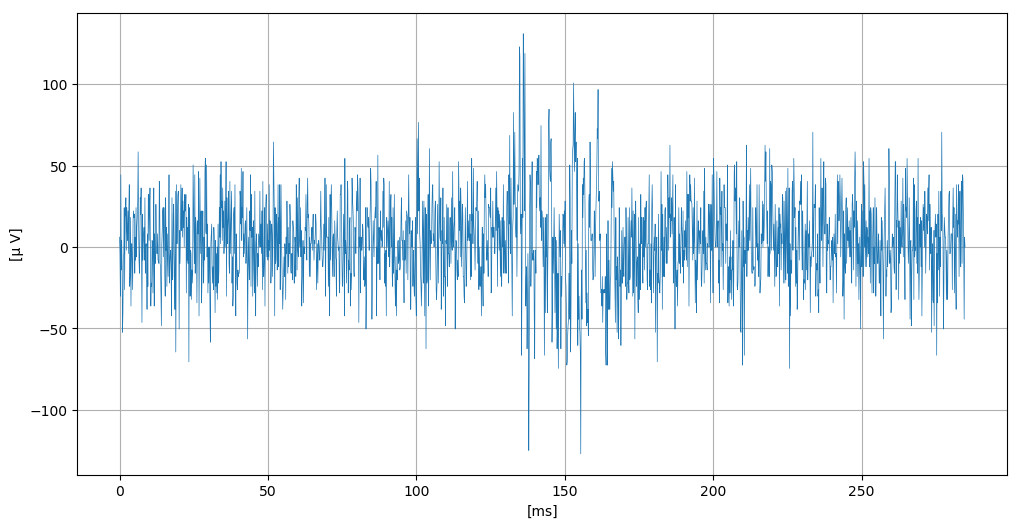

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6db3f956a0>

In [14]:
figura=figure(figsize=(12,6))
grid()
#xlim(120,170)
xlabel("[ms]")
ylabel("[μ V]")
plot(rangotiempos, ejemplolfp, lw=0.5)

In [15]:
plan=plan_fft(ejemplolfp,  flags=FFTW.PATIENT)
fttotal=(plan*ejemplolfp);
ftsym=circshift(fttotal, div(nmax,2));

In [16]:
div(102,2)

51

In [17]:
epoder=map(abs2, ftsym);

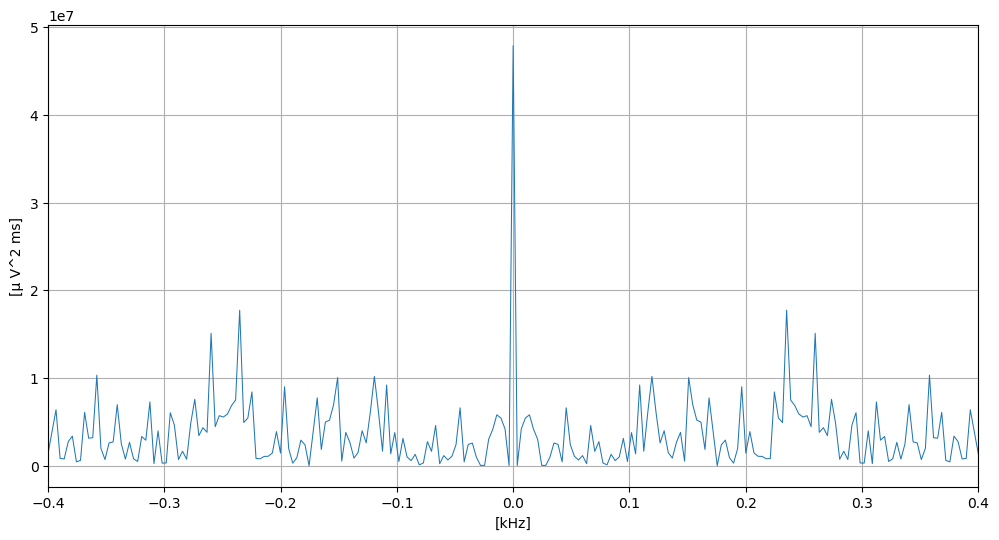

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6db42e08d0>

In [18]:
figura=figure(figsize=(12,6))
grid(which="both")
xlim(-0.4,0.4)
xlabel("[kHz]")
ylabel("[μ V^2 ms]")
#yscale("log")
mediorango=1:500
plot(rfreqsim,epoder, lw=0.74)
#plot(rangofreqs[mediorango],epoder2[mediorango])

In [19]:
function indicecercano(a::Number, freqs::Array)
    #encuentra en índice que tiene el número  más cercano a "a" en el Array freqs
    # si a está más lejos de alguno de ellos que su paso
    tol=abs((max(freqs)-min(freqs))/length(freqs))
    result=findfirst(x->isapprox(a,x, atol=tol), freqs)
    return result
end

function indicecercano(a::Number, freqs::StepRangeLen)
    #encuentra en índice que tiene el número  más cercano a "a" en el Array freqs
    # si a está más lejos de alguno de ellos que su paso
    tol=step(freqs)
    result=findfirst(x->isapprox(a,x, atol=tol), freqs)
    return result
end


indicecercano (generic function with 2 methods)

In [20]:
?iseven

search: iseven isinteractive



```
iseven(x::Integer) -> Bool
```

Return `true` is `x` is even (that is, divisible by 2), and `false` otherwise.

# Examples

```jldoctest
julia> iseven(9)
false

julia> iseven(10)
true
```


In [21]:
function filtrobanda(freqs, yys::Array, a::Float64, b::Float64 )
    #filtro pasa banda para DFT anular con rango [0, freqmax)
    if a>b
        b,a=a,b
    end
    abajo=indicecercano(a,freqs)
    arriba=indicecercano(b, freqs)
    result=deepcopy(yys)
    l=length(yys)
    laux=l+1
    if !(iseven(l))
        #ajustar indices
        laux+=1
    end
   # println( "los indices aceptables seran: ")
   # println( "abajo = ", abajo, " arriba = ", arriba, " laux-arriba = ", laux-arriba, " laux - abajo =", laux-abajo)
    for w in 1:l
        if ! (( abajo < w < arriba ) || (laux-arriba)<w<(laux-abajo) )
        result[w]=0
        end
    end
    return result
end

filtrobanda (generic function with 1 method)

In [22]:
rangofreqs.step

Base.TwicePrecision{Float64}(0.003509274462041692, 0.0)

In [23]:
rara2=filtrobanda(rangofreqs, fttotal, 0.001,0.05);

In [24]:
fttotal[2:14]

13-element Array{Complex{Float64},1}:
  136.48315111440212 - 60.28345245771507im 
   261.8093166811417 + 2036.1922769266293im
 -1259.2325028683504 - 1962.4162723842996im
    1491.23470812692 + 1892.567979244483im 
  -1351.387059172689 - 1522.4783058920634im
     1219.7875707673 + 1237.8035041436062im
  -194.0513681720272 - 55.76399730304175im 
  -174.3366264619329 + 88.69835447262493im 
   818.4487849329419 - 542.9053024313612im 
  -654.4261788067222 + 1469.2587911842693im
   60.05255433672721 - 1558.029107933492im 
  -658.9069957031631 + 54.127633771127876im
   2017.978724639123 - 1591.87569429435im  

In [25]:
fttotal[1989:2001]

13-element Array{Complex{Float64},1}:
   2017.978724639123 + 1591.8756942943505im
  -658.9069957031631 - 54.12763377112758im 
  60.052554336727695 + 1558.0291079334918im
   -654.426178806722 - 1469.2587911842693im
   818.4487849329419 + 542.9053024313615im 
 -174.33662646193295 - 88.69835447262463im 
 -194.05136817202765 + 55.76399730304172im 
  1219.7875707672993 - 1237.8035041436065im
 -1351.3870591726889 + 1522.4783058920632im
  1491.2347081269204 - 1892.5679792444832im
 -1259.2325028683501 + 1962.4162723842996im
  261.80931668114215 - 2036.192276926629im 
  136.48315111440235 + 60.283452457715im   

Muy bien, hasta ahí parece funcionar. Hay que checar que esto también jale con indices pares. Ahora aplicamos a esto a los datos completos.

In [26]:
ffTotalTotal=zeros(Complex, 64, 64, nmax);
for j=1:64, k=1:64
    ffTotalTotal[j,k,:]=plan*vec(lfp[j,k,:])
end

In [27]:
# = funciones auxiliares para bandas "ineteresantes =#
fbajas(datos)=filtrobanda(rangofreqs,datos, 0.010, 0.060)
fmedias(datos)=filtrobanda(rangofreqs, datos, 0.1, 0.2)
faltas(datos)=filtrobanda(rangofreqs, datos, 0.2, 0.3)
faltotas(datos)=filtrobanda(rangofreqs, datos, 0.3, 0.45)

faltotas (generic function with 1 method)

Las unidades son un relajo. Tenemos que $V^2 \cdot s$ ( Volts cuadrados por segundos ) son Joules entre Coulombs. La transformada de Fourier esta en $ V \cdot s$, Volts segundos. Al cuadrar y multiplicar por $ d \omega$,nos da otra vez $ V^2 s$ que esta bien. Pero nuestra señal esta en $mV \cdot ms$. Eso da que la Transformada de Fourier está en $10^{-6} Vs$. Al cuadrar queda en $10^{-12}$, y nuestra $d \omega$ esta en kHz. Por ende el resultado de la integral esta en $10^{-9} J/C$.

In [28]:
factor=10^9
poderbajo=zeros(Real, 64,64)
podermedio=zeros(Real, 64,64)
poderalto=zeros(Real, 64,64)
poderaltote=zeros(Real, 64,64)
for j=1:64, k=1:64
    aux=fbajas(ffTotalTotal[j,k,:])
    poderbajo[j,k]=convert(Real, dot(aux,aux))/factor
    aux=fmedias(ffTotalTotal[j,k,:])
    podermedio[j,k]=convert(Real, dot(aux,aux))/factor
    aux=faltas(ffTotalTotal[j,k,:])
    poderalto[j,k]=convert(Real, dot(aux,aux))/factor
    aux=faltotas(ffTotalTotal[j,k,:])
    poderaltote[j,k]=convert(Real, dot(aux,aux))/factor
end

In [29]:
extrema(poderalto)

(0.02751395777115315, 46.728563982087806)

In [39]:
satux=saturados[:,2]
satuy=saturados[:,1]
bonsx=buenos[:,2]
bonsy=buenos[:,1];

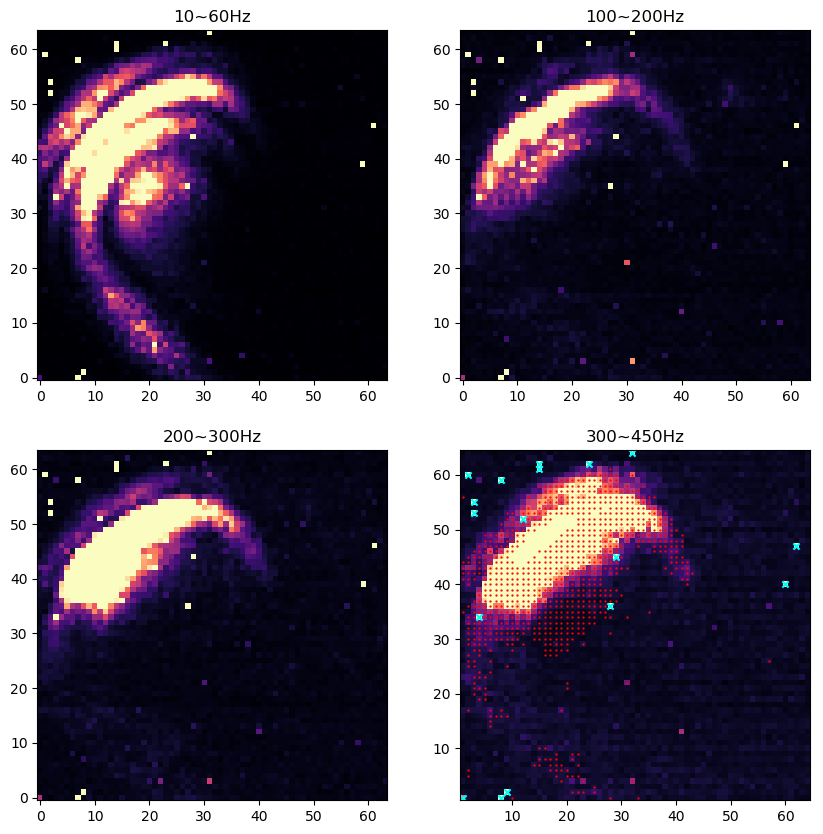

In [49]:
farofa, lista =subplots(2,2, figsize=(10,10))

(pmin, pmax)= (0, 2)

exten=[0.5,64.5,0.5,64.5]

lista[1,1][:imshow](poderbajo, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[1,1][:title][:set_text]("10~60Hz")

lista[1,2][:imshow](podermedio, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[1,2][:title][:set_text]("100~200Hz")

lista[2,1][:imshow](poderalto, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[2,1][:title][:set_text]("200~300Hz")

lista[2,2][:imshow](poderaltote, vmin=pmin, vmax=pmax, origin="lower", cmap="magma", extent=exten)
lista[2,2][:title][:set_text]("300~450Hz")

scatter(bonsx, bonsy, marker="o", c="red", s=0.4)
scatter(satux, satuy, marker="x", c="cyan", s=20)


#farofa[:colorbar](lista[2,2], ax=lista, orientation="horizontal", fraction=.1)

savefig("EspectrosdePoderporBandas.png", dpi=90)

#colorbar()

In [51]:
function wfft(datos::Array, cuadros::Int)
#hace un fftw por ventanas, lo que hace que tengamos un array de una dimension mas.
    r=1:cuadros
    nredux=length(datos)-cuadros
    plan=plan_fft(datos[r])
    result=zeros(Complex, nredux, cuadros)
    for j=1:nredux
        raux=r.+j
        result[j,:]=plan*datos[raux]
    end
    return result
end

wfft (generic function with 1 method)

In [56]:
skt=wfft(ejemplolfp, 350);
ranguitof=(0:349).*(freq/350)

0.0:0.0200630234244155:7.001995175121009

In [60]:
epoder=map(abs2, skt)./factor;

In [64]:
extrema(epoder)

(0.0, 0.009504667091541288)

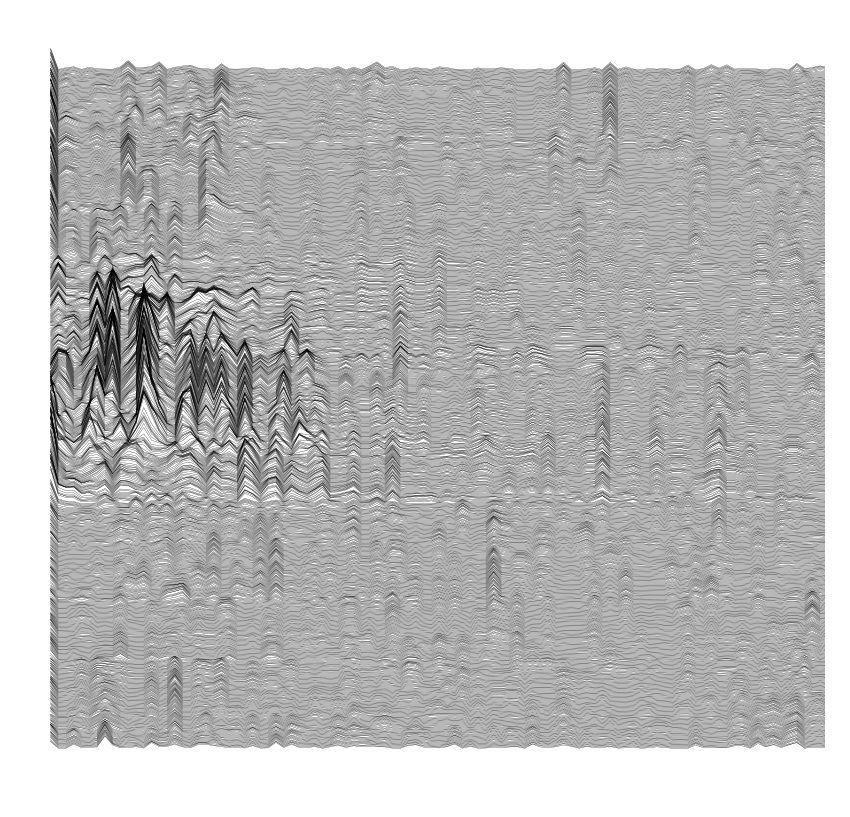

In [78]:
f=figure(figsize=(10,10))
xlim(0,2)
axis("off")

for j=1:2:(nmax-351)
    datos=vec(epoder[j+1,:]).+(j*0.00005)
    plot(ranguitof, datos, lw=0.2, c="black")
end

savefig("texturadefrequenciasparaAnaPaula01.png", dpi=90)


In [107]:
a,b=size(epoder)
xx=collect(1:a)
yy=collect(1:b);

xxs=repeat(xx,outer=(1,b))
yys=permutedims(repeat(yy, outer=(1,a)))

xxs=xxs./freq
yys=yys.*(freq/350)

#plot_wireframe(xxs, yys, epoder)

1651×350 Array{Float64,2}:
 0.020063  0.040126  0.0601891  …  6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891  …  6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891  …  6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 0.020063  0.040126  0.0601891     6.96187  6.98193  7.002  7.02206
 ⋮                              ⋱                                  
 0.020063  0.040126  

In [108]:
xxs

1651×350 Array{Float64,2}:
   0.142408    0.142408    0.142408  …    0.142408    0.142408    0.142408
   0.284817    0.284817    0.284817       0.284817    0.284817    0.284817
   0.427225    0.427225    0.427225       0.427225    0.427225    0.427225
   0.569634    0.569634    0.569634       0.569634    0.569634    0.569634
   0.712042    0.712042    0.712042       0.712042    0.712042    0.712042
   0.85445     0.85445     0.85445   …    0.85445     0.85445     0.85445 
   0.996859    0.996859    0.996859       0.996859    0.996859    0.996859
   1.13927     1.13927     1.13927        1.13927     1.13927     1.13927 
   1.28168     1.28168     1.28168        1.28168     1.28168     1.28168 
   1.42408     1.42408     1.42408        1.42408     1.42408     1.42408 
   1.56649     1.56649     1.56649   …    1.56649     1.56649     1.56649 
   1.7089      1.7089      1.7089         1.7089      1.7089      1.7089  
   1.85131     1.85131     1.85131        1.85131     1.85131     1.85131

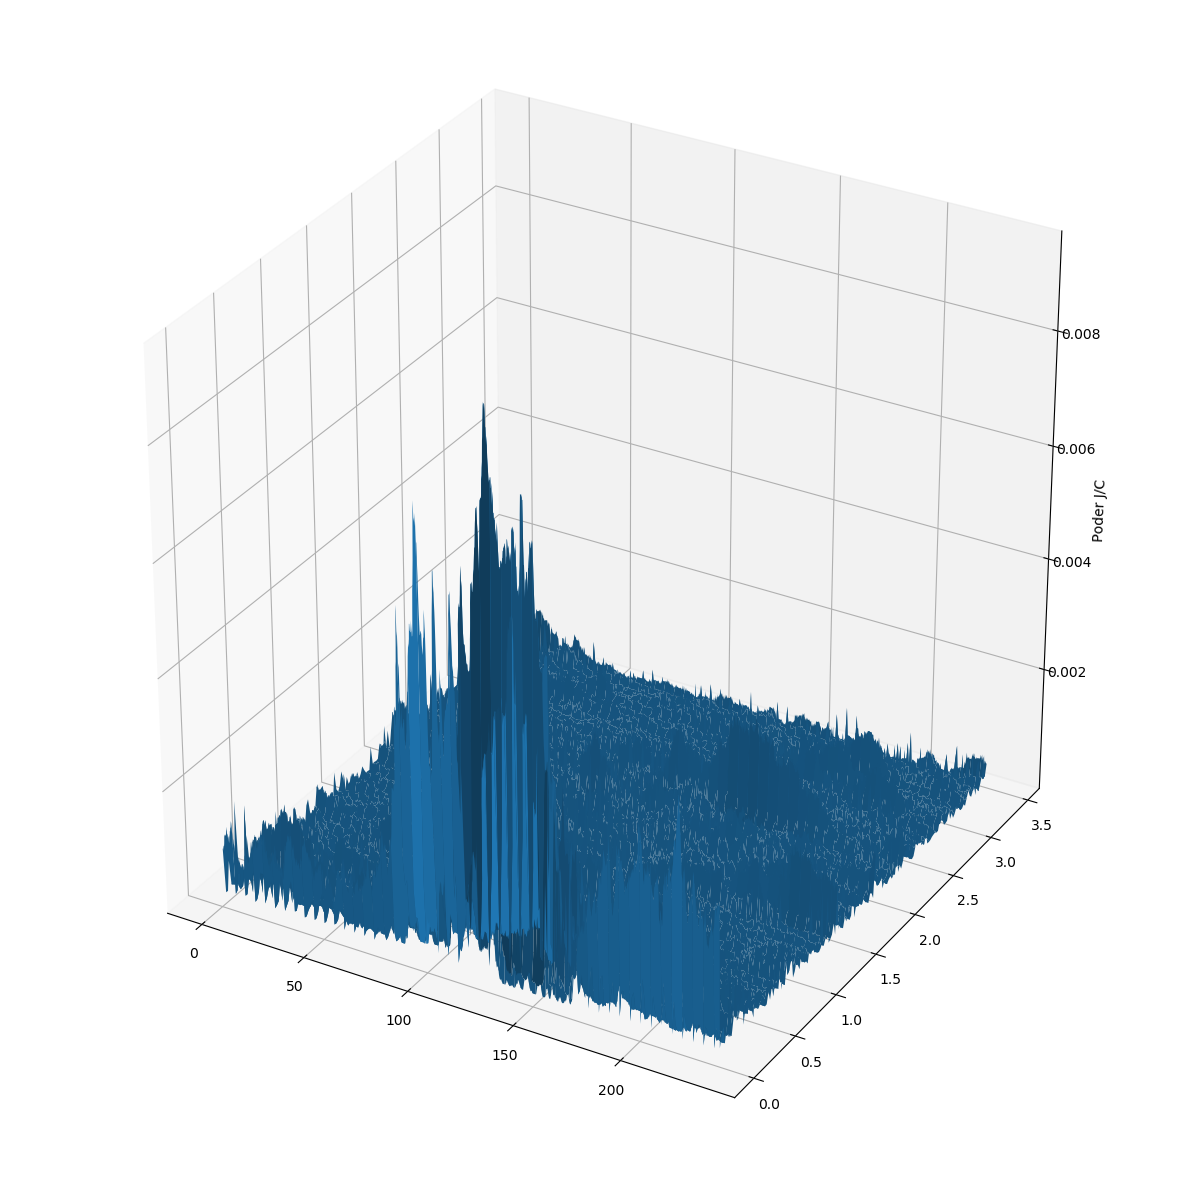

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7f6d6e5c0c88>

In [118]:
f=figure(figsize=(15,15))
ylim(0,3.5)
xlabel("Tiempo ms")
ylabel("frequencia kHz")
zlabel("Poder J/C")
plot_surface(xxs[:,1:170], yys[:,1:170], epoder[:,1:170], lw=0.5)

In [115]:
?view

search: view @view @views DivideError vlines axvline evalfile readavailable



```
view(A, inds...)
```

Like [`getindex`](@ref), but returns a view into the parent array `A` with the given indices instead of making a copy.  Calling [`getindex`](@ref) or [`setindex!`](@ref) on the returned `SubArray` computes the indices to the parent array on the fly without checking bounds.

# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Array{Int64,2}:
 1  2
 3  4

julia> b = view(A, :, 1)
2-element view(::Array{Int64,2}, :, 1) with eltype Int64:
 1
 3

julia> fill!(b, 0)
2-element view(::Array{Int64,2}, :, 1) with eltype Int64:
 0
 0

julia> A # Note A has changed even though we modified b
2×2 Array{Int64,2}:
 0  2
 0  4
```


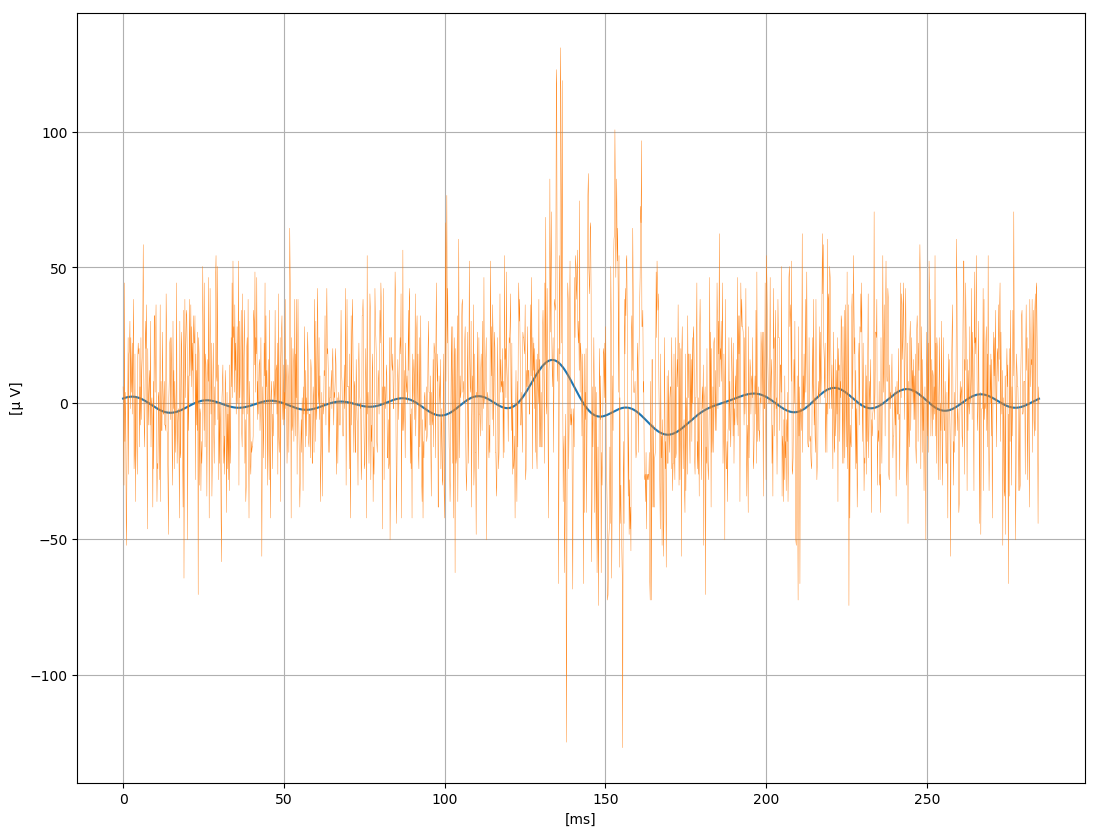

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff0b3453320>

In [71]:
figura=figure(figsize=(13,10))
grid()
#xlim(120,170)
xlabel("[ms]")
ylabel("[μ V]")
#plot(rangotiempos, signalfiltrad, lw=1.5)
plot(rangotiempos, signalfiltrad2, lw=1.5)
#plot(rangotiempos, signalfiltrad+signalfiltrad2, lw=1.65)
plot(rangotiempos, ejemplolfp, lw=0.3)


In [29]:
a=0.053022
tol=2*step(rangofreqs)
q(x)=isapprox(a,x, atol=tol)
findfirst(q, rangofreqs)


14

In [30]:
rangofreqs[12:17]

0.0421112935445003:0.003509274462041692:0.05965766585470876

In [31]:
map(q, rangofreqs[12:17])

6-element Array{Bool,1}:
 false
 false
  true
  true
  true
  true

In [32]:
collect(rangofreqs[12:17])

6-element Array{Float64,1}:
 0.0421112935445003  
 0.045620568006541996
 0.049129842468583686
 0.05263911693062538 
 0.05614839139266707 
 0.05965766585470876 

In [33]:
step(rangofreqs)

0.003509274462041692

In [34]:
a=0.005
p=indicecercano(a, rangofreqs)

1

In [35]:
rangofreqs[2]

0.007018548924083384

In [36]:
rangofreqs[57]

0.20002864433637643

In [37]:
figura=figure(figsize=(12,6))
grid()
xlabel("[kHz]")
ylabel("[μ V^2]")
plot(subfreqs,epoder2)

UndefVarError: UndefVarError: subfreqs not defined